In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue

print('setup done.')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

setup done.


In [ ]:
# Import libraries
import os
import cv2
import numpy as np
from pathlib import Path

# Define input and output base directories
input_base_dir = "/kaggle/input/corals-classification/Bleached Corals and Healthy Corals Classification"  
output_base_dir = "/kaggle/working/coral_enhanced"     

# Function to enhance a single image
def enhance_image(image_path, output_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return

    # Step 1: CLAHE for contrast enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)                    # Split into L (lightness), A, B channels
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))  # Create CLAHE object
    l_enhanced = clahe.apply(l)                 # Apply CLAHE to lightness channel
    lab_enhanced = cv2.merge((l_enhanced, a, b))  # Merge back
    img_enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)  # Convert back to BGR

    # Step 2: Light Gaussian blur for noise reduction
    img_denoised = cv2.GaussianBlur(img_enhanced, (5, 5), 0)  # Small kernel to keep details

    # Step 3: Histogram stretching per channel for color correction
    for i in range(3):  
        channel = img_denoised[:, :, i]
        min_val, max_val = np.percentile(channel, (5, 95))  
        channel = np.clip((channel - min_val) * 255 / (max_val - min_val), 0, 255)
        img_denoised[:, :, i] = channel.astype(np.uint8)

    cv2.imwrite(output_path, img_denoised)

for split in ['Training', 'Validation', 'Testing']:
    input_split_dir = os.path.join(input_base_dir, split)
    output_split_dir = os.path.join(output_base_dir, split)
    
    # Process both healthy_corals and bleached_corals subfolders
    for category in ['healthy_corals', 'bleached_corals']:
        input_category_dir = os.path.join(input_split_dir, category)
        output_category_dir = os.path.join(output_split_dir, category)
        
        Path(output_category_dir).mkdir(parents=True, exist_ok=True)
        
        if os.path.isdir(input_category_dir):
            for image_file in os.listdir(input_category_dir):
                if image_file.lower().endswith(('.jpg', '.png')):  # Handle common image formats
                    input_image_path = os.path.join(input_category_dir, image_file)
                    output_image_path = os.path.join(output_category_dir, image_file)
                    enhance_image(input_image_path, output_image_path)
        else:
            print(f"Directory not found: {input_category_dir}")

print("Image enhancement completed for all splits!")

Image enhancement completed for all splits!


In [3]:
import shutil

#shutil.rmtree('/kaggle/working')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import math

base_dir = "/kaggle/working/coral_enhanced"
train_dir = os.path.join(base_dir, "Training")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Testing")

# Set image size and batch size (optimized for Kaggle)
IMG_SIZE = (224, 224)  
BATCH_SIZE = 64  

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', classes=['healthy_corals', 'bleached_corals'], shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', classes=['healthy_corals', 'bleached_corals'], shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', classes=['healthy_corals', 'bleached_corals'], shuffle=False
)

print(f"Training samples: {train_generator.n}")
print(f"Validation samples: {val_generator.n}")
print(f"Testing samples: {test_generator.n}")
print("Class indices:", train_generator.class_indices)

Found 7384 images belonging to 2 classes.
Found 985 images belonging to 2 classes.
Found 923 images belonging to 2 classes.
Training samples: 7384
Validation samples: 985
Testing samples: 923
Class indices: {'healthy_corals': 0, 'bleached_corals': 1}


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Keep frozen

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)  
x = BatchNormalization()(x)           
x = Dropout(0.3)(x)                  
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, mode='max', verbose=1)
checkpoint = ModelCheckpoint('/kaggle/working/coral_health_best_model_1.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=1, min_lr=1e-6, verbose=1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
history = model.fit(
    train_generator,
    epochs=20,  
    validation_data=val_generator,
    validation_steps=math.ceil(val_generator.n / BATCH_SIZE),
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

model.save('/kaggle/working/coral_health_final_model_1.h5')
print("Training completed! Best model saved as 'coral_health_final_model.h5'")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.6794 - loss: 0.7188
Epoch 1: val_accuracy improved from -inf to 0.74924, saving model to /kaggle/working/coral_health_best_model_1.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 105s 744ms/step - accuracy: 0.6796 - loss: 0.7180 - val_accuracy: 0.7492 - val_loss: 0.5116 - learning_rate: 0.0020
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 79s 643ms/step - accuracy: 0.7442 - loss: 0.5238 - learning_rate: 0.0020
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.7544 - loss: 0.5038
Epoch 3: val_accuracy improved from 0.74924 to 0.77056, saving model to /kaggle/working/coral_health_best_model_1.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 672ms/step - accuracy: 0.7544 - loss: 0.5038 - val_accuracy: 0.7706 - val_loss: 0.4835 - learning_rate: 0.0020
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 81s 660ms/step - accuracy: 0.7526 - loss: 0.4947 - learning_rate: 0.0020
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.7515 - loss: 0.5012
Epoch 5: val_accuracy improved from 0.77056 to 0.77868, saving model to /kaggle/working/coral_health_best_model_1.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 84s 682ms/step - accuracy: 0.7515 - loss: 0.5012 - val_accuracy: 0.7787 - val_loss: 0.4625 - learning_rate: 0.0020
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 82s 664ms/step - accuracy: 0.7604 - loss: 0.4939 - learning_rate: 0.0020
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.7668 - loss: 

In [ ]:
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

test_loss, test_acc = model.evaluate(
    test_generator,
    steps=math.ceil(test_generator.n / BATCH_SIZE)
)
print(f"Test Accuracy: {test_acc:.4f}")

Final Training Accuracy: 0.7879
Final Validation Accuracy: 0.7939
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step - accuracy: 0.8339 - loss: 0.3714
Test Accuracy: 0.8267


In [8]:
import os
#os.remove('/kaggle/working/coral_health_best_model_1.keras')

In [9]:
final_val_loss = history.history['val_loss'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Validation Loss: 0.4249
Final Validation Accuracy: 0.7939


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


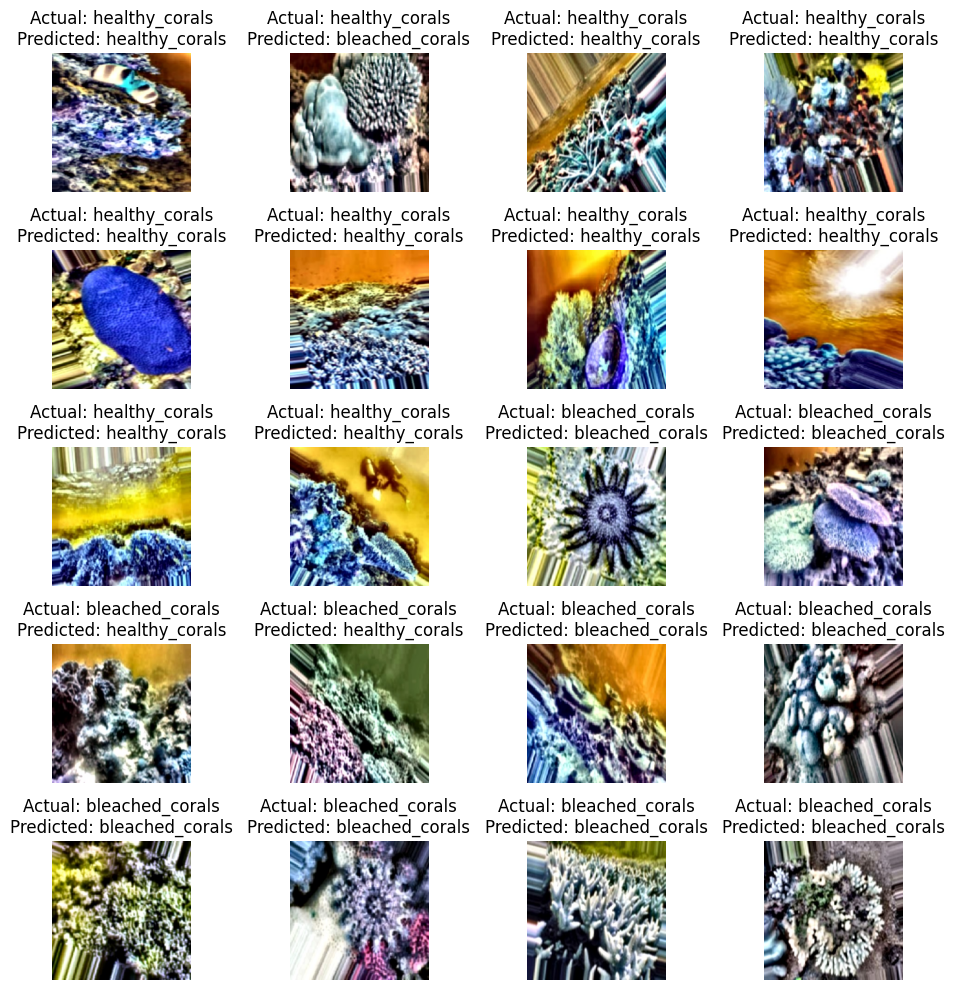

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

model = tf.keras.models.load_model('/kaggle/working/coral_health_final_model_1.h5')

test_dir = "/kaggle/working/coral_enhanced/Testing"
class_labels = ['healthy_corals', 'bleached_corals']

all_images = []
for class_label in class_labels:
    class_path = os.path.join(test_dir, class_label)
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    all_images.extend(random.sample(images, min(10, len(images))))  # 10 per class

plt.figure(figsize=(10, 10))
for i, img_path in enumerate(all_images[:20]):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    predicted_label = "bleached_corals" if prediction > 0.5 else "healthy_corals"
    actual_label = "bleached_corals" if "bleached_corals" in img_path else "healthy_corals"

    plt.subplot(5, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

plt.tight_layout()
plt.show()